# Zero to Deep Learning in 60 (ish) Minutes

System requirements for those following along at home:
- This document lives at https://github.com/jeffschecter/sandbox/ (along with a bunch of broken experiments that mostly don't work)
- `pip install numpy matplotlib`
- And install TensorFlow: https://www.tensorflow.org/versions/r0.7/get_started/os_setup.html

## Syllabus
1. (5 min) Tiny Images of Horses, Dogs, and Planes
2. (5 min) Evidence That Deep Learning is Really Neat
3. (10 min) Neural Networks Are Just Matrix Multiplication
4. (10 min) Rolling Marbles Down Hills
5. (10 min) Convolutional Neural Networks (which are Still Just Matrix Multiplication)

In [1]:
import numpy as np
import tensorflow as tf

import load_cifar10
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Tiny Images of Horses, Dogs, and Planes
(https://www.cs.toronto.edu/~kriz/cifar.html)

CIFAR-10 is a collection of 60,000 tiny 32 x 32 images of horses, dogs, planes, and things.

Includes 6,000 images of each of 10 different images categories.

In [2]:
image_batches, label_batches = load_cifar10.Batches(include_labels=True)
train_image_batches = image_batches[:5]
train_label_batches = label_batches[:5]
train_images = np.concatenate(train_image_batches)
train_labels = np.concatenate(train_label_batches)
test_images = image_batches[5]
test_labels = label_batches[5]

In [3]:
train_labels_one_hot = np.zeros((50000, 10))
train_labels_one_hot[np.arange(50000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

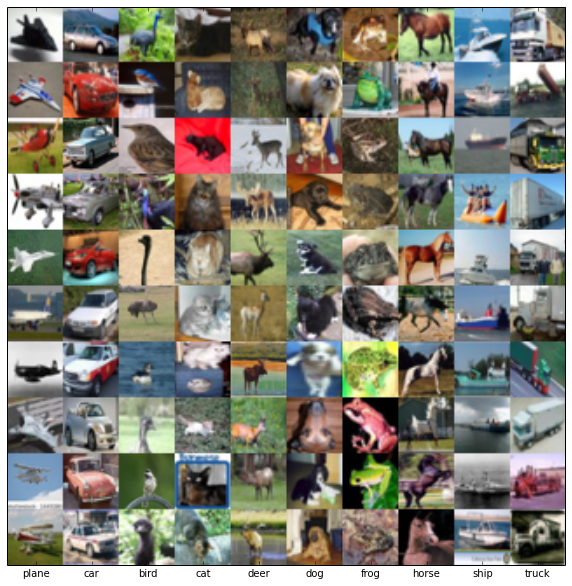

In [4]:
figsize(10, 10)
categories = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.imshow(np.concatenate(
    [train_images[train_labels == x][:10].reshape(320, 32, 3)
     for x in xrange(10)], axis=1))
plt.xticks(
    np.arange(10) * 32 + 16,
    categories)
plt.yticks([])
plt.show()

For each category, 5,000 images are for **TRAINING**, and 1,000 images are for **TESTING**.

A common benchmark in machine learning is to feed an algorithm those 50k training images, then see how well it does at sorting the 10k test images into their respective categories.

<center><font color="red">
<h3>Your mission, should you choose to accept it:</h3>
<h2>Achieve 90%+ Accuracy on Identifying the CIFAR-10 Test Set</h2>
</font></center>

(Which is actually pretty hard!)

# 2. Evidence that Deep Learning is Really Neat

### They're 3-4x Better At Image Classification Than Humans
<a href="http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/">
    <img src="http://karpathy.github.io/assets/ilsvrc1.png">
</a>
(image credit Andrej Karpathy)

The ImageNet Large Scale Visual Recognition Competition (ILSVRC) task requires sorting 150k real images into **one thousand** different object categories. 1.2 million annotated images are available for training. <a href="http://arxiv.org/pdf/1512.03385v1.pdf">Microsoft Research's latest submission</a> achieves an error rate of just 3.57% on the test images.

<a href="http://karpathy.github.io/2014/09/02/what-i-learned-from-competing-against-a-convnet-on-imagenet/">Andrej Karpathy reports</a> that humans get error rates of 13%-15% on the same task.

### They can write like Shakespeare
If in a rambling, plotless way. Credit again to <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Andrej Karpathy</a>:

```
Second Lord:
They would be ruled after this chamber, and
my fair nues begun out of the fact, to be conveyed,
Whose noble souls I'll have the heart of the wars.

Clown:
Come, sir, I will make did behold your worship.

VIOLA:
I'll drink it.
```

### They can perform analogical reasoning through vector math
Google developed this algorithm, called "word2vec". A neural net reads a very large amount of text, with the task of predicting the context surrounding each word. The net's internal representations end up having an interesting property: vectors for different words can be added or subtracted to perform crude analogical reasoning. <a href="http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/">From the StitchFix blog</a>:

<img src="http://multithreaded.stitchfix.com/assets/images/blog/vectors.gif">

### They can compose music
<a href="http://www.hexahedria.com/2015/08/03/composing-music-with-recurrent-neural-networks/">blog post</a>

### They can color greyscale images
<a href="http://tinyclouds.org/colorize/">blog post</a>

<img src="http://tinyclouds.org/colorize/best/12.jpg">

### They can re-draw images in a new style
See <a href="http://arxiv.org/pdf/1508.06576v2.pdf">the paper by Gatys, Ecker, & Bethge</a>.

<img src="http://i.imgur.com/gG4fvAC.jpg">

### And lots more.
Machine translation, object localization, voice to text, image and audio comparison, dimensionality reduction, denoising, time series prediction, exploration of latent spaces, ... 

# 3. Neural Networks are Just Matrix Multiplication

"Deep learning" is just a catch phrase to make neural networks sound sexy again. For a while—like, 20 years—they were really un-sexy. To emphasize the fact that now the cool kids like them, we use buzzwords.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg">
(from Stanford's <a href="http://cs231n.github.io/neural-networks-1/">cs231 course</a>)

A neural network is a series of matrix multiplications followed by elementwise applications of non-linear functions.

But first, tensors.

### Everything Is Tensors

Quick sidebar: A tensor is a generalization of a matrix. All your favorite matrix operations, like dot products and cross products, generalize to tensors of arbitrary rank. Yay!

A scalar value, like <span style="font-family: monospace; color: blue;">0.5</span>, is a tensor of rank 0.

A vector, like <span style="font-family: monospace; color: blue;">[0.5, 0.25, 0.125]</span>, is a tensor of rank 1.

A matrix is a tensor of rank 2. You can think of a greyscale image as a matrix, with each value indicating the brightness of a pixel.

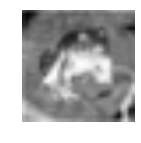

In [5]:
figsize(2, 2)
plt.imshow(np.dot(train_images[0], [.21, .72, .07]), cmap=cm.Greys_r)
plt.axis("off")
plt.show()

But we can go higher! In deep learning, we use tensors of rank 3 to represent full color images. You can think of a rank 3 tensor as a stack of matrices. For color images, we use a stack of three matrices: the top matrix indicates how red each pixel in the image is, the middle matrix how green, and the bottom matrix how blue.

You could also use a rank 3 tensor to represent a greyscale video. The first matrix in the stack is the image in the video frame at the first time step, the second matrix is the image at the second step, and so on.

Or you could use a rank 3 tensor to represent a stack of unrelated greyscale images.

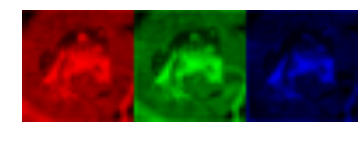

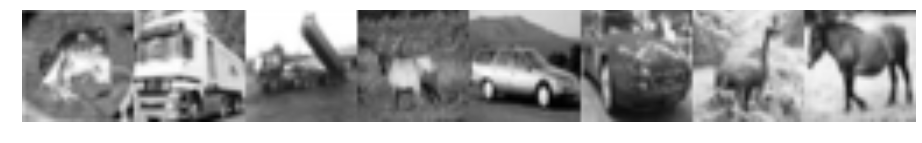

In [6]:
figsize(6, 2)
im = train_images[0]
plt.imshow(np.concatenate(
    [im * [1, 0, 0], im * [0, 1, 0], im * [0, 0, 1]],
    axis=1))
plt.axis("off")
plt.show()

figsize(16, 2)
plt.imshow(
    np.dot(np.concatenate(list(train_images[:8]), axis=1),
       [0.21, 0.72, 0.07]),
    cmap=cm.Greys_r)
plt.axis("off")
plt.show()

In the same way, we can use a rank 4 tensor to represent a full color video, a stack of greyscale videos, or a stack of color images

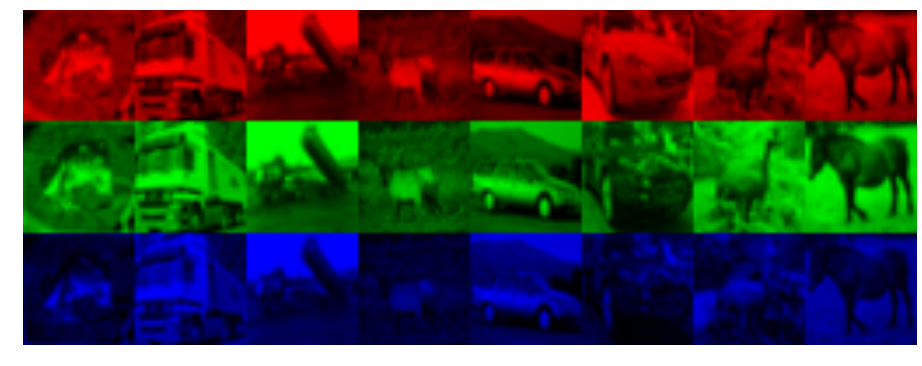

In [7]:
figsize(16, 6)
plt.imshow(np.concatenate(
    [np.concatenate([im * [1, 0, 0], im * [0, 1, 0], im * [0, 0, 1]], axis=0)
     for im in train_images[:8]],
    axis=1))
plt.axis("off")
plt.show()

Or a rank 5 tensor to represent a stack of color videos.

Say you had a magic camera that could capture full color 3D video. You might represent a stack of color 3D videos as a rank 6 tensor.

And so on. Today we'll stick to rank 4 tensors (representing stacks of color images) and below.

### Representing our Inputs and Outputs as Tensors
Remember our goal of identifying CIFAR-10 images? Let's work on that a bit.

We could represent our color image inputs as rank 3 tensors of shape [32, 32, 3]: 32 pixels long the x axis, 32 pixels along the y axis, and 3 colors. But for our simple example, we don't really need to, so we'll just flatten that into a vector length 32 x 32 x 3, ie, a rank 1 tensor of shape [3072].

For output, we'll use a vector, or rank 1 tensor, of shape [10]. That's one index for each object category. We'll decide, some what arbitrarily, that the indices in this vector correspond, in order, to:

<span style="font-family: monospace; color: blue;">[planes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks]</span>

And we'll say we want the value at each index to be the probability that the network thinks that the input image belongs to the corresponding category.

So ideally this input:

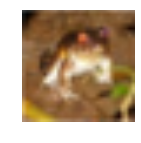

In [8]:
figsize(2, 2)
plt.imshow(train_images[0])
plt.axis("off")
plt.show()

produces this output:

<span style="font-family: monospace; color: blue;">[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]</span>

Meaning, "I think there is a 100% chance that this image is a frog and a 0% chance that it is anything else."

Someting like this:

<span style="font-family: monospace; color: blue;">[0, 0, 0, 0, 0, 0.1, 0.85, 0.1, 0, 0.05]</span>

"I think there's a 85% chance that this image is a frog, a 10% chance it's a dog, 10% it's a horse, and 5% it's a truck", would also be pretty good!

### Matrix Multiplication

In case you forgot:

A neural network is a series of matrix multiplications followed by elementwise applications of non-linear functions.

So, our goal is to transform a tensor of shape [3072] into a tensor of shape [10] through a series of matrix multiplications. We could do this in one step by multiplying our input tensor by a *weight matrix* of shape [3072, 10].

But for reasons I'll explain later, we'll do it in two steps: first multiply the input by a tensor of shape [3072, 100], then the result of that operation by a tensor of shape [100, 10].

Check out this simple implementation:

In [26]:
weight_1 = np.random.normal(0, 0.1, size=[3072, 100])
weight_2 = np.random.normal(0, 0.1, size=[100, 10])

def NeuralNetwork(image, w1, w2):
    input_tensor = image.flatten()
    hidden = np.matmul(input_tensor, w1)
    out = np.matmul(hidden, w2)
    return out

def ApplyNetAndDisplayResults(*args):
    figsize(2, 2)
    plt.imshow(args[0])
    plt.axis("off")
    plt.show()
    network_output = NeuralNetwork(*args)
    values, labels = zip(*sorted(zip(network_output, categories), reverse=True))
    figsize(8, 4)
    plt.bar(np.arange(10), values, alpha=0.5)
    plt.xticks(np.arange(10) + 0.5, labels)
    plt.show()

Let's test it out! We've initialized our weight matrices to have small values centered around 0, with a standard deviation of 0.1. There's no reason to expect these untrained weights to know what's a bird versus a plane versus a frog.

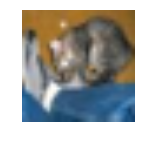

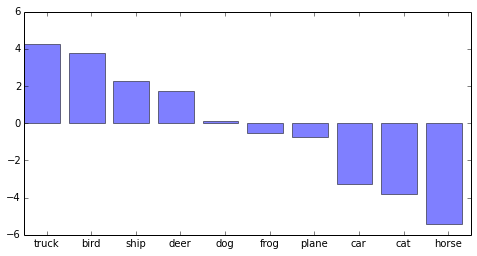

In [27]:
ApplyNetAndDisplayResults(test_images[0], weight_1, weight_2)

This, of course, doesn't make any damn sense. Not only does it make the incorrect guess, but it doesn't obey the premise that outputs should correspond to probabilities—it is impossible for there to be a 500% chance that the image is a plane and a 480% chance that it's a ship and a -200% chance that it's a truck, or whatever.

### Nonlinearities and The Softmax Function

Remember:

A neural network is a series of matrix multiplications followed by elementwise applications of non-linear functions.

Why do we multiply by non-linear functions? To increase expressive power.

Right now, the mapping from inputs to outputs that our network expresses could be expressed just as easily with a single matrix multiplication. No need to do it in two steps.

However, that's not true if we apply some non-linear function, like tanh or the sigmoid, to each element in the output of the first matrix multiplication. Applying a non-linearity lets us express much more complex mappings.

In the simplest case, it's impossible to express the XOR "eclusive or" function with a straight matrix multiplication, but easy to do it with a matmul, followed by a nonlinearity, followed by another matmul.

                                     A Selection of Common Nonlinearities:
            tanh, sigmoid, Rectified Linear Unit (ReLU), Leaky ReLU, and Exponential Linear Unit (ELU)


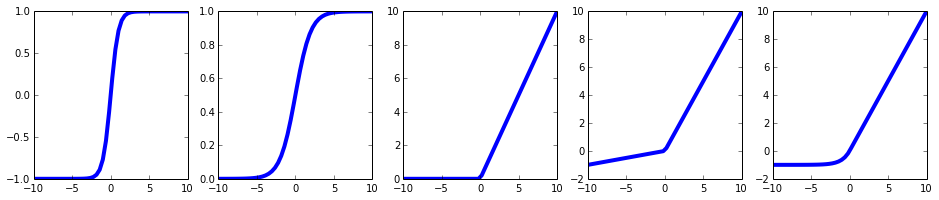

In [28]:
print "                                     A Selection of Common Nonlinearities:"
print "            tanh, sigmoid, Rectified Linear Unit (ReLU), Leaky ReLU, and Exponential Linear Unit (ELU)"
figsize(16, 3)
_, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
x = np.linspace(-10, 10)
ax0.plot(x, np.tanh(x), linewidth=4)
ax1.plot(x, 1 / (1 + np.exp(-x)), linewidth=4)
ax2.plot(x, x * (x > 0), linewidth=4)
ax3.plot(x, x * (x > 0) + x * 0.1 * (x < 0), linewidth=4)
ax4.plot(x, x * (x > 0) + (x < 0) * (np.exp(x) - 1), linewidth=4)
plt.show()

A special nonlinearity called the softmax takes a vector and normalizes it such that its elements sum to 1. The softmax is a super duper choice to apply at the final layer of a neural network if you want the output to represent probabilities.

<img src="https://upload.wikimedia.org/math/f/e/6/fe662496a60a965b4d51e0befb778398.png">

So, let's use the tanh nonlinearity after the first matrix multiplication, and softmax after the second.

In [29]:
def Softmax(vec):
    exps = np.exp(vec)
    return exps / np.sum(exps)

def NeuralNetwork(image, w1, nl1, w2, nl2):
    input_tensor = image.flatten()
    hidden = nl1(np.matmul(input_tensor, w1))
    out = nl2(np.matmul(hidden, w2))
    return out

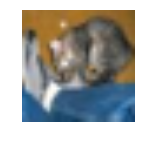

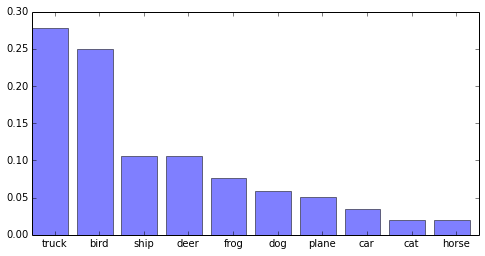

In [30]:
ApplyNetAndDisplayResults(test_images[0], weight_1, np.tanh, weight_2, Softmax)

Well that looks a little nicer! Our network now nicely maps the input space to the output space.

It's still completely wrong, but at least the results are now interpretable in the way we want.

So, how do we get the network to learn?

# 4. Rolling Marbles Down Hills

Our neural network currently produces results that are very, very wrong.

And its operation depends on two weight matrices which, at the moment, are full of random gibberish.

So.

Think of all the weights in those weight matrices as picking out some point on a hyperplane. Very, very hyper: a 308,200 dimensional hyperplane. Wowza. That's hard. So imagine there are just two weights, for a moment, picking out points on a 2D plane. Every point on this plane represents a possible configuration of our network's weight matrices.

Now envision a wrinkly surface hanging above that plane. And let's say the ***height*** of this surface at any point represents how ***wrong*** our network would be, if we used the weight matrix picked out by the point on the plane directly below it.

To find the best possible weight matrix—the weight matrix that makes our network the least wrong—well, we just drop a marble on this surface, let it roll down hill, and see where it ends up.

<img src="http://i.imgur.com/2dKCQHh.jpg">
(image credit <a href="http://www.hexahedria.com/2015/08/03/composing-music-with-recurrent-neural-networks/">Daniel Johnson</a>)

So let's do that.

It works just as well in 308,200 dimensions as in 2.

## Convex Optimization

In order to roll marbles down hills, we need to:

1. Define the height of the hill
2. Find "down"

### Height of the Hill: Error Functions

To get a measurement of how wrong we are, we'll run our network on a bunch of training examples for which we know the desired output, or target. We'll then apply some function that takes as arguments the network output and the target, and produces a single number. This number should be 0 when the network is correct, and higher when the network is more wrong.

#### Cross Entropy

When working with a classification problem, it is standard to use an error function called <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross entropy</a>. Cross entropy is an information theoretic measure of the difference between two probability distributions—one "reference" distribution and one "unnatural" distribution—that operate over the same events.

Cross entropy is defined as follows for probability distributions p and q over some set of events x:

<img src="https://upload.wikimedia.org/math/8/7/5/875c6f70e04e4a2ddf50a69d54533847.png">

### Direction of Down: Partial Derivatives

Once you've defined your error function, calculating the direction of downhill is easy: the vector pointing downhill in parameter-space is the partial derivative of each parameter with respect to the error function.

#### What This Means for Choosing Nonlinearities

Notice that the slope of those S-shaped nonlinearities, the sigmoid and tanh, is very small for extremely large or extremely small inputs. That means that their partial derivatives are often near 0, which causes convex optimization to be very, very slow—or impossible, when you add in numerical stability issues. We call this the "vanishing gradient problem". So:

<span style="color: red; font-weight: bold">IF YOU USE S-SHAPED NONLINEARITIES, YOU WILL (probably) HAVE A BAD TIME.</span>

You probably want to use ReLU or something similar instead.

## The Training Algorithm

Putting it all together, here's how you train a neural network.

1. Initialize your weight matrices to random values.
2. Run your network on a bunch of training examples, and find the average error.
3. Find the partial derivative of each weight in each weight matrix with respect to error.
4. Adjust each weight by an amount equal to its partial derivative multiplied by some learning rate.
5. Keep doing that until error is low or you run out of time.

## TensorFlow

Implementing partial derivatives for whatever weird nonlinearities and error functions you come up with and propogating them through the neural network is tedious! Lots of smart people have spent lots of time creating libraries that do this for you. I like to use <a href="https://www.tensorflow.org/">Google's TensorFlow</a>.

TensorFlow does a few things:
1. Express Tensor Operations as Directed Acyclic Graphs
2. Execute those DAGs very efficiently on CPU or GPU
3. One-Liner Convex Optimization

Let's re-write our network in TensorFlow. At the same time, we'll re-write it to run on stacks of a bunch of images at the same time, rather than just a single image.

In [14]:
# TensorFlow uses a session object to execute your computation graph.
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


In [15]:
# A TensorFlow placeholder is an input node of the DAG computation.
# Our input images are a stack any number of images deep, 32 px wide, 32 px high, with 3 color channels.
input_images = tf.placeholder(tf.float32, [None, 32, 32, 3], name="InputImages")

# Flatten each image in the stack.
flattened = tf.reshape(input_images, [-1, 32 * 32 * 3])

# Multiply by a weight matrix, add biases, then apply the ReLU nonlinearity.
W_hidden = tf.Variable(
    tf.random_normal([32 * 32 * 3, 100], mean=0, stddev=0.02),
    name="WeightsHidden")
b_hidden = tf.Variable(
    tf.random_normal([100], mean=0, stddev=0.02),
    name="BiasHidden")
h_hidden = tf.nn.relu(tf.matmul(flattened, W_hidden) + b_hidden)

# Multiply by a weight matrix, add biases, then apply the Softmax nonlinearity.
W_out = tf.Variable(
    tf.random_normal([100, 10], mean=0, stddev=0.02),
    name="WeightsOut")
b_out = tf.Variable(
    tf.random_normal([10], mean=0, stddev=0.02),
    name="BiasOut")
h_out = tf.nn.softmax(tf.matmul(h_hidden, W_out) + b_out)

# Calculate accuracy and error
targets = tf.placeholder(tf.float32, [None, 10], name="TargetLabels")
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(h_out, 1), tf.argmax(targets, 1)), tf.float32))
err = -tf.reduce_mean(targets * tf.log(h_out))

# Use the Adam Optimizer with a Learning Rate of 0.001
train_step = tf.train.AdamOptimizer(0.001).minimize(err)

In [16]:
sess.run(tf.initialize_all_variables())

#### Train the Network

In [17]:
batch_size = 1000
epochs = 100
batches_per_epoch = train_images.shape[0] / batch_size

test_acs = []
test_errs = []
train_acs = []
train_errs = []

# At initialization
test_ac, test_err = sess.run([accuracy, err], feed_dict={
    input_images: test_images,
    targets: test_labels_one_hot})
test_acs.append((0, test_ac))
test_errs.append((0, test_err))
print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
    a=test_ac * 100, e=test_err)

for ep in xrange(epochs):
    
    # Shuffle our training data
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels_one_hot = train_labels_one_hot[indices]
    
    # Train
    print "\nStarting training epoch {ep}".format(ep=ep)
    for i in xrange(batches_per_epoch):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        _, train_ac, train_err = sess.run(
            [train_step, accuracy, err],
            feed_dict={
                input_images: train_images[start_offset:stop_offset],
                targets: train_labels_one_hot[start_offset:stop_offset]})
        train_acs.append((ep * batches_per_epoch + i, train_ac))
        train_errs.append((ep * batches_per_epoch + i, train_err))
        if (i + 1) % 25 == 0:
            print "Epoch {ep}, batch {ba}: Training Accuracy = {a:.1f}%, Training Error = {e:.5f}".format(
                ep=ep, ba=i, a=train_ac * 100, e=train_err)

    # Test
    test_ac, test_err = sess.run([accuracy, err], feed_dict={
        input_images: test_images,
        targets: test_labels_one_hot})
    test_acs.append(((ep + 1) * batches_per_epoch, test_ac))
    test_errs.append(((ep + 1) * batches_per_epoch, test_err))
    print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
        a=test_ac * 100, e=test_err)
    

Test Accuracy = 10.2%, Test Error = 0.23019

Starting training epoch 0
Epoch 0, batch 24: Training Accuracy = 32.8%, Training Error = 0.19349
Epoch 0, batch 49: Training Accuracy = 33.0%, Training Error = 0.18968
Test Accuracy = 33.3%, Test Error = 0.18861

Starting training epoch 1
Epoch 1, batch 24: Training Accuracy = 35.3%, Training Error = 0.18317
Epoch 1, batch 49: Training Accuracy = 36.3%, Training Error = 0.18394
Test Accuracy = 36.9%, Test Error = 0.17982

Starting training epoch 2
Epoch 2, batch 24: Training Accuracy = 38.5%, Training Error = 0.17579
Epoch 2, batch 49: Training Accuracy = 37.7%, Training Error = 0.17665
Test Accuracy = 38.8%, Test Error = 0.17386

Starting training epoch 3
Epoch 3, batch 24: Training Accuracy = 39.5%, Training Error = 0.17528
Epoch 3, batch 49: Training Accuracy = 39.8%, Training Error = 0.17531
Test Accuracy = 40.5%, Test Error = 0.17004

Starting training epoch 4
Epoch 4, batch 24: Training Accuracy = 40.6%, Training Error = 0.16837
Epoch 

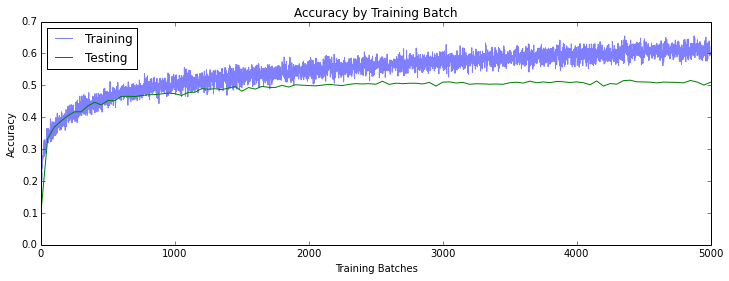

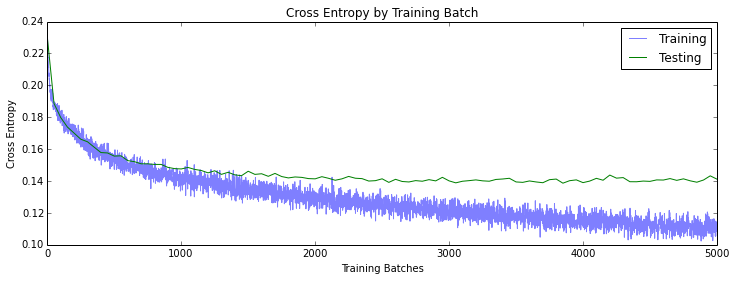

In [18]:
figsize(12, 4)
plt.plot(*zip(*train_acs), alpha=0.5, label="Training")
plt.plot(*zip(*test_acs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Accuracy by Training Batch")
plt.show()

plt.plot(*zip(*train_errs), alpha=0.5, label="Training")
plt.plot(*zip(*test_errs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Cross Entropy")
plt.legend(loc="best")
plt.title("Cross Entropy by Training Batch")
plt.show()

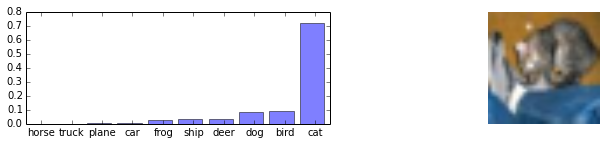

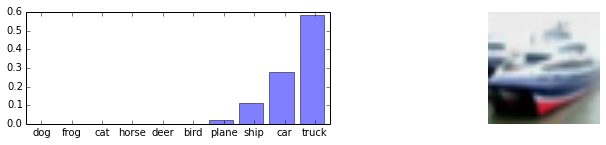

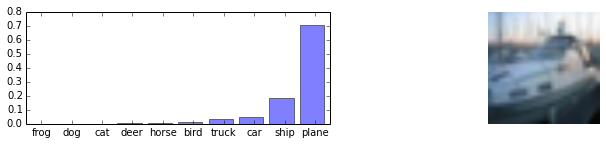

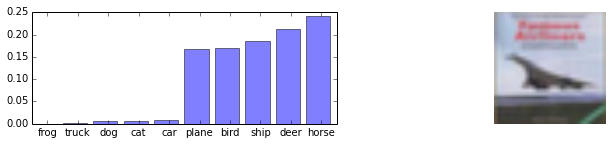

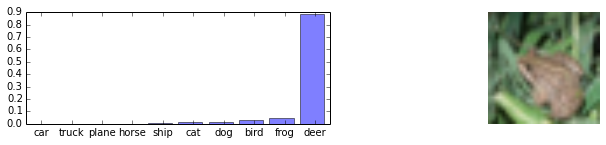

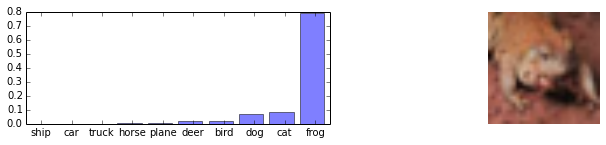

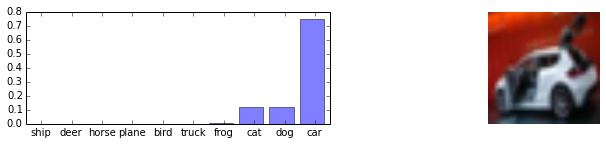

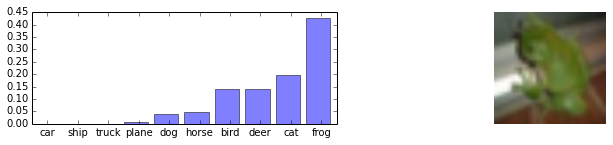

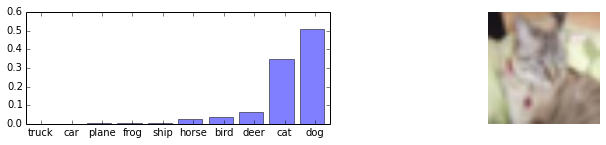

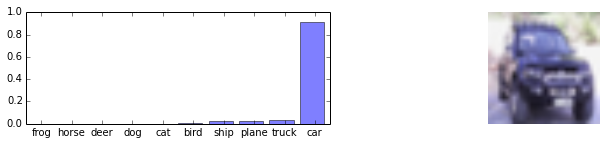

In [19]:
figsize(12, 2)
for i in xrange(10):
    _, (ax0, ax1) = plt.subplots(1, 2)
    ax1.imshow(test_images[i])
    ax1.axis("off")
    scores, labels = zip(*sorted(zip(
        h_out.eval(feed_dict={input_images: test_images[i:i+1]}).reshape(10),
        categories)))
    ax0.bar(np.arange(10), scores, alpha=0.5)
    ax0.set_xticks(np.arange(10) + 0.5)
    ax0.set_xticklabels(labels)
    plt.show()

It looks like test set accuracy tops out around 51%. Not too shabby, especially considering how blurry some of those images are. But we set a goal for ourselves of 90% accuracy. We need a more powerful tool. We need...

# 5. Convolutional Neural Networks (which are Still Just Matrix Multiplication)

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">
(from <a href="http://cs231n.github.io/convolutional-networks/">cs231</a> again)

Here's an intuition: If an image has an eye in it somewhere, it's more likely to be a cat or a dog than a boat or a plane. If an image has a wheel in it somewhere, it's more likely to be a truck. Doesn't really matter where.

The network we trained above treats each color channel of each pixel as completely separate and unrelated. It has no concept of spatial organization, no capacity to represent concepts like "eye" or "wheel".

Convolutional neural networks take advantage of the spatial structure of images and reduce the number of trainable parameters in the network at the same time.

They do this by restricting each unit to receiving information only from a small patch of spatially adjacent units in the layer below. This prserves spatial information when moving from one layer to the next. Illustrated in one dimension:

<img src="http://deeplearning.net/tutorial/_images/sparse_1D_nn.png">

Further, the weight matrix that projects a patch at layer N to a unit at layer N + 1 isn't just applied at that particular spot. Instead, it's tiled across the whole layer, applied at every possible position. In essence, we're checking every spot at layer N for the presence of some feature. If that feature probably exists at layer N, the corresponding unit at layer N + 1 will have a high activation. If the feature is probably absent at layer N, the corresponding unit at layer N + 1 will have a low activation.

<img src="http://deeplearning.net/tutorial/_images/conv_1D_nn.png">

(Images from the Theano <a href="http://deeplearning.net/tutorial/lenet.html">tutorial on convnets</a>)

For the lower layers in the network, these tiled weight matrices (also called "kernels" or "convolutions" or "channels") learn to find extremely basic features, like edges. Intermediate layers learn to detect things like rudiemntary shapes; higher level layers learn more abstract representations like eyes and wheels.

We apply many convolutions at once to each layer. When we apply, say, 16 convolutions to a color image, it's kind of like going from a 3-channel image to a 16-channel image. The hope is that each convolutional kernal learns to detect something different: this one edges, this one corners, that one swatches of darkness, and so on.

We typically alternate convolutional layers with an operation called max pooling: Divide the layer up into small regions, and take the maximum value of any unit in the region. This helps us reduce the amount of computation performed by the network and encourage the creation of more abstract representations.

I've created a few functions in the `ops` library to help facilitate convolutional operations.

In [20]:
# TensorFlow uses a session object to execute your computation graph.
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [21]:
with tf.name_scope("ConvNet") as ns:
    
    # Here we're actualy representing stacks of color images as rank 4 tensors.
    input_images = tf.placeholder(tf.float32, [None, 32, 32, 3], name="InputImages")

    # Convolutional layer that projects a 5x5 patch of pixels onto a unit in the next layer,
    # then applies the ReLLU nonlinarity. We start with 16 convolutional kernels.
    conv_1 = ops.ConvLayer(input_images, 5, 16, tf.nn.relu, "Conv1")

    # Project 3x3 patches onto the next layer, apply ReLU nonlinarity, stay with 16 kernels,
    # then apply max pooling across 2x2 regions. Representation size should now be 16x16.
    conv_2 = ops.ConvLayer(conv_1, 3, 16, ops.ELU, "Conv2")
    mp_1 = tf.nn.max_pool(conv_2, (1, 2, 2, 1), (1, 2, 2, 1), "VALID")

    # Project 3x3 patches onto the next layer, apply ReLU nonlinarity, use 64 kernels,
    # then apply max pooling across 2x2 regions. Representation size should now be 8x8.
    conv_3 = ops.ConvLayer(mp_1, 3, 64, ops.ELU, "Conv3")
    mp_2 = tf.nn.max_pool(conv_3, (1, 2, 2, 1), (1, 2, 2, 1), "VALID")

    # Flatten the representation then run through a fully connected layer.
    flattened = tf.reshape(mp_2, [-1, 8 * 8 * 64])
    W_out, b_out, h_out = ops.HiddenLayer(flattened, [8 * 8 * 64, 10], nonlin=tf.nn.softmax)

    # Calculate accuracy and error
    targets = tf.placeholder(tf.float32, [None, 10], name="TargetLabels")
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(h_out, 1), tf.argmax(targets, 1)), tf.float32))
    err = -tf.reduce_mean(targets * tf.log(h_out))

    # Use the Adam Optimizer with a Learning Rate of 0.001
    train_step = tf.train.AdamOptimizer(0.001).minimize(err)

In [22]:
sess.run(tf.initialize_all_variables())

#### Train the Network

In [23]:
batch_size = 1000
epochs = 100
batches_per_epoch = train_images.shape[0] / batch_size

test_acs = []
test_errs = []
train_acs = []
train_errs = []

# At initialization
test_ac, test_err = sess.run([accuracy, err], feed_dict={
    input_images: test_images,
    targets: test_labels_one_hot})
test_acs.append((0, test_ac))
test_errs.append((0, test_err))
print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
    a=test_ac * 100, e=test_err)

for ep in xrange(epochs):
    
    # Shuffle our training data
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels_one_hot = train_labels_one_hot[indices]
    
    # Train
    print "\nStarting training epoch {ep}".format(ep=ep)
    for i in xrange(batches_per_epoch):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        _, train_ac, train_err = sess.run([train_step, accuracy, err], feed_dict={
            input_images: train_images[start_offset:stop_offset],
            targets: train_labels_one_hot[start_offset:stop_offset]})
        train_acs.append((ep * batches_per_epoch + i, train_ac))
        train_errs.append((ep * batches_per_epoch + i, train_err))
        if (i + 1) % 25 == 0:
            print "Epoch {ep}, batch {ba}: Training Accuracy = {a:.1f}%, Training Error = {e:.5f}".format(
                ep=ep, ba=i, a=train_ac * 100, e=train_err)

    # Test
    test_ac, test_err = sess.run([accuracy, err], feed_dict={
        input_images: test_images,
        targets: test_labels_one_hot})
    test_acs.append(((ep + 1) * batches_per_epoch, test_ac))
    test_errs.append(((ep + 1) * batches_per_epoch, test_err))
    print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
        a=test_ac * 100, e=test_err)
    

Test Accuracy = 9.2%, Test Error = 0.23026

Starting training epoch 0
Epoch 0, batch 24: Training Accuracy = 28.0%, Training Error = 0.20362
Epoch 0, batch 49: Training Accuracy = 32.8%, Training Error = 0.19048
Test Accuracy = 33.8%, Test Error = 0.18833

Starting training epoch 1
Epoch 1, batch 24: Training Accuracy = 37.4%, Training Error = 0.17453
Epoch 1, batch 49: Training Accuracy = 41.4%, Training Error = 0.16635
Test Accuracy = 41.2%, Test Error = 0.16650

Starting training epoch 2
Epoch 2, batch 24: Training Accuracy = 43.7%, Training Error = 0.16117
Epoch 2, batch 49: Training Accuracy = 45.5%, Training Error = 0.16018
Test Accuracy = 45.0%, Test Error = 0.15552

Starting training epoch 3
Epoch 3, batch 24: Training Accuracy = 47.2%, Training Error = 0.15375
Epoch 3, batch 49: Training Accuracy = 45.2%, Training Error = 0.15240
Test Accuracy = 46.4%, Test Error = 0.15232

Starting training epoch 4
Epoch 4, batch 24: Training Accuracy = 48.5%, Training Error = 0.14498
Epoch 4

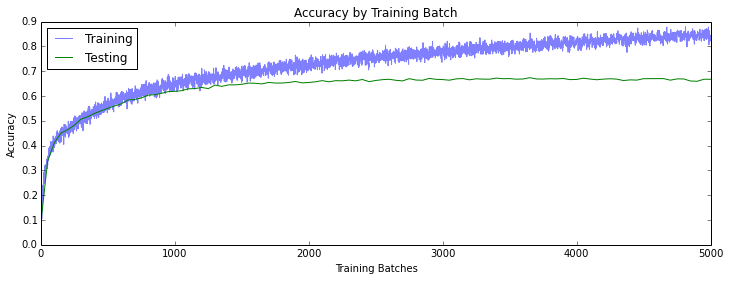

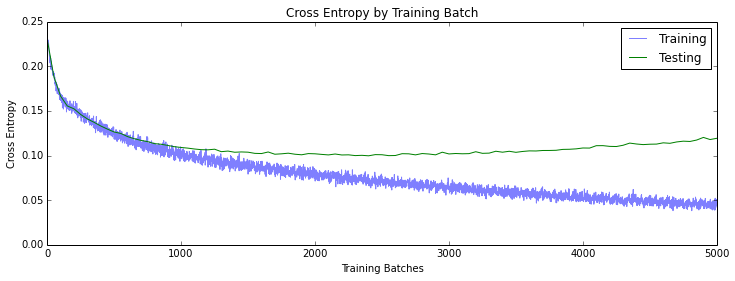

In [24]:
figsize(12, 4)
plt.plot(*zip(*train_acs), alpha=0.5, label="Training")
plt.plot(*zip(*test_acs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Accuracy by Training Batch")
plt.show()

plt.plot(*zip(*train_errs), alpha=0.5, label="Training")
plt.plot(*zip(*test_errs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Cross Entropy")
plt.legend(loc="best")
plt.title("Cross Entropy by Training Batch")
plt.show()

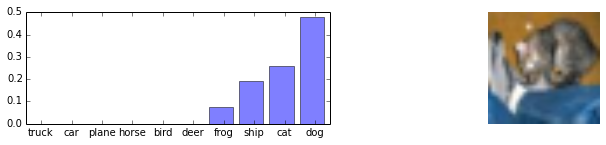

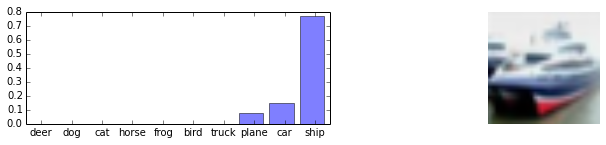

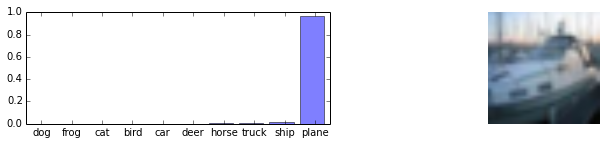

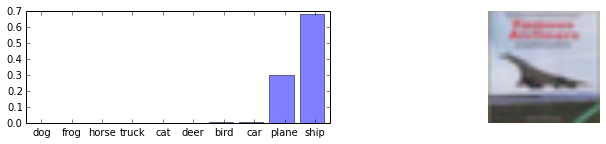

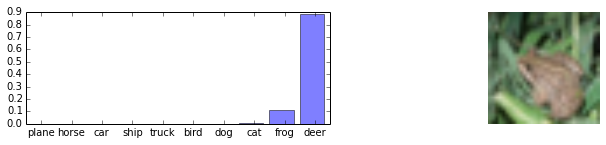

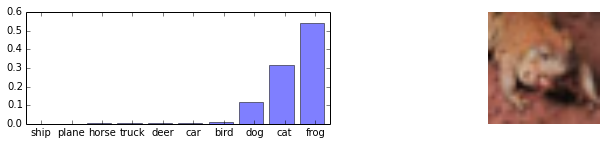

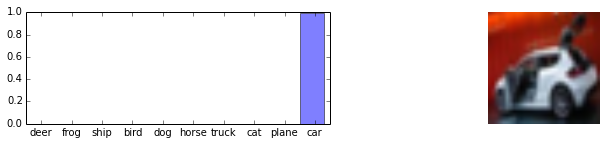

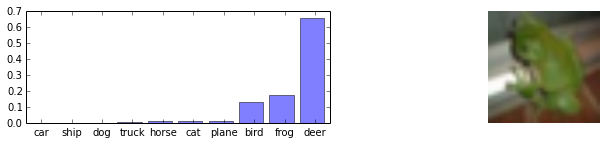

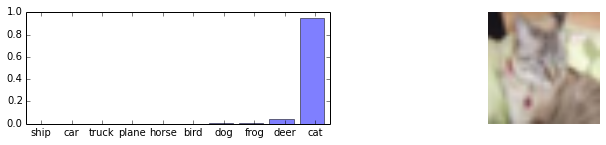

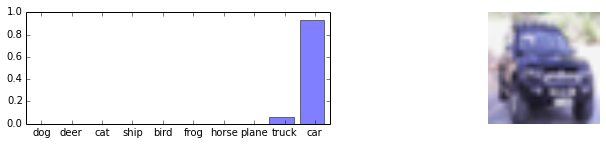

In [25]:
figsize(12, 2)
for i in xrange(10):
    _, (ax0, ax1) = plt.subplots(1, 2)
    ax1.imshow(test_images[i])
    ax1.axis("off")
    scores, labels = zip(*sorted(zip(
        h_out.eval(feed_dict={input_images: test_images[i:i+1]}).reshape(10),
        categories)))
    ax0.bar(np.arange(10), scores, alpha=0.5)
    ax0.set_xticks(np.arange(10) + 0.5)
    ax0.set_xticklabels(labels)
    plt.show()

### Let's Crack Open the Hood

And see what the convolutional kernels discovered.

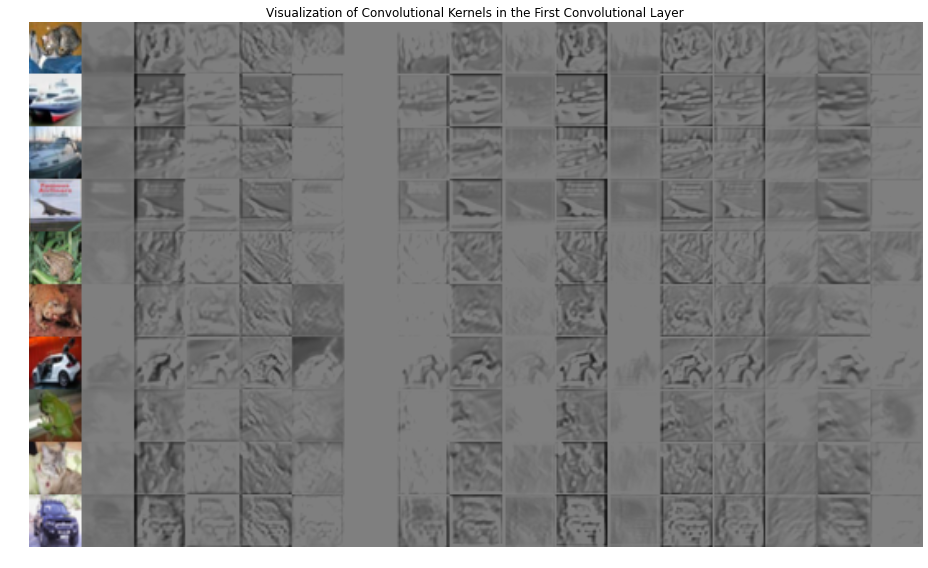

In [86]:
figsize(16, 10)
ims = []
krs = []
kernels = 1 / (1 + np.exp(-conv_1.eval(feed_dict={input_images: test_images[:10]})))
for i in xrange(10):
    ims.append(test_images[i])
    kr = kernels[i]
    kr_grey = np.concatenate([kr[:, :, j] for j in xrange(16)], axis=1)
    kr_color = np.stack([1 - kr_grey, 1 - kr_grey, 1 - kr_grey], axis=2)
    krs.append(kr_color)
plt.imshow(np.concatenate(
    [np.concatenate(ims, axis=0),
     np.concatenate(krs, axis=0)],
    axis=1))
plt.axis("off")
plt.title("Visualization of Convolutional Kernels in the First Convolutional Layer")
plt.show()

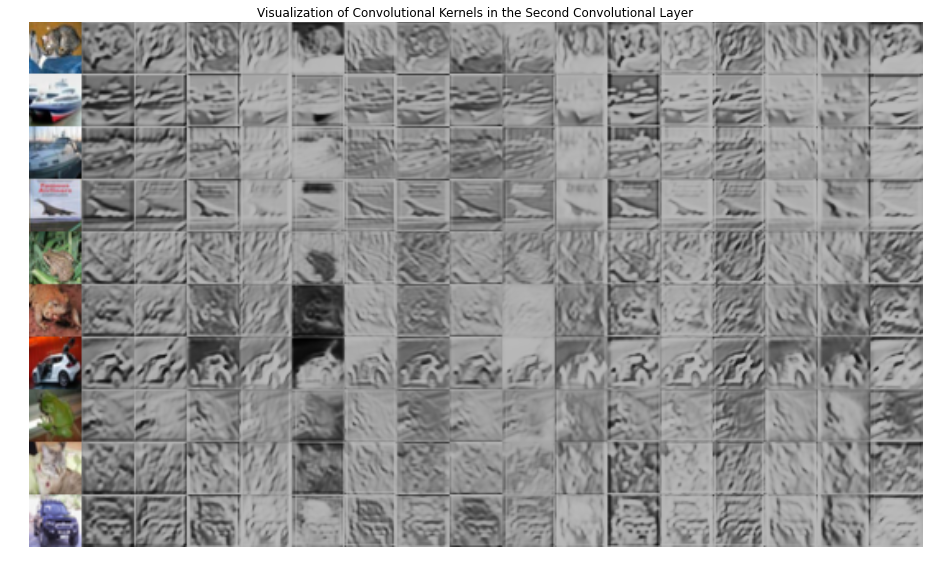

In [87]:
figsize(16, 10)
ims = []
krs = []
kernels = 1 / (1 + np.exp(-conv_2.eval(feed_dict={input_images: test_images[:10]})))
for i in xrange(10):
    ims.append(test_images[i])
    kr = kernels[i]
    kr_grey = np.concatenate([kr[:, :, j] for j in xrange(16)], axis=1)
    kr_color = np.stack([1 - kr_grey, 1 - kr_grey, 1 - kr_grey], axis=2)
    krs.append(kr_color)
plt.imshow(np.concatenate(
    [np.concatenate(ims, axis=0),
     np.concatenate(krs, axis=0)],
    axis=1))
plt.axis("off")
plt.title("Visualization of Convolutional Kernels in the Second Convolutional Layer")
plt.show()

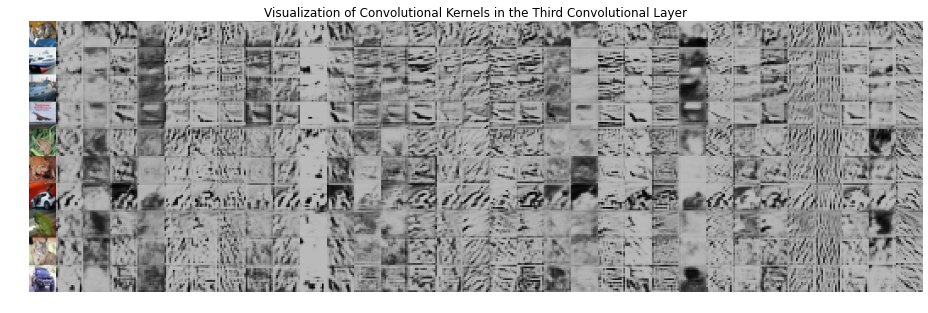

In [92]:
figsize(16, 5)
ims = []
krs = []
kernels = 1 / (1 + np.exp(-conv_3.eval(feed_dict={input_images: test_images[:10]})))
for i in xrange(10):
    ims.append(test_images[i])
    kr = kernels[i]
    kr_grey = np.concatenate([kr[:, :, j] for j in xrange(32)], axis=1)
    kr_color = np.stack([1 - kr_grey, 1 - kr_grey, 1 - kr_grey], axis=2)
    krs.append(kr_color.repeat(2, axis=0).repeat(2, axis=1))
plt.imshow(np.concatenate(
    [np.concatenate(ims, axis=0),
     np.concatenate(krs, axis=0)],
    axis=1))
plt.axis("off")
plt.title("Visualization of Convolutional Kernels in the Third Convolutional Layer")
plt.show()